<a href="https://colab.research.google.com/github/thaais-souza/AmigoSecreto/blob/main/TelecomX2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 📌 Importação de Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# 🔧 Carregar dados tratados
df = pd.read_csv("dados_tratados.csv")
print("Primeiras 5 linhas dos dados tratados:")
print(df.head())



Primeiras 5 linhas dos dados tratados:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   
2  {'InternetService': 

In [5]:
# Verificar se temos a coluna Churn_numeric
if 'Churn_numeric' not in df.columns:
    # Criar coluna Churn_numeric se não existir
    df['Churn_numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 1. Preparar os dados para modelagem
print("Preparando dados para modelagem...")

# Separar features (X) e target (y)
# Excluir colunas não relevantes para o modelo
colunas_nao_usadas = ['customerID', 'Churn']
X = df.drop(colunas_nao_usadas + ['Churn_numeric'], axis=1, errors='ignore')
y = df['Churn_numeric']

# Verificar se há colunas categóricas que precisam ser codificadas
colunas_categoricas = X.select_dtypes(include=['object']).columns
if len(colunas_categoricas) > 0:
    print(f"Colunas categóricas encontradas: {list(colunas_categoricas)}")
    # Codificar variáveis categóricas usando one-hot encoding
    X = pd.get_dummies(X, columns=colunas_categoricas, drop_first=True)

# Verificar se há valores missing
if X.isnull().sum().sum() > 0:
    print("Tratando valores missing...")
    # Preencher valores missing com a mediana para numéricos
    for col in X.columns:
        if X[col].dtype in ['int64', 'float64']:
            X[col].fillna(X[col].median(), inplace=True)
        else:
            # Para colunas categóricas já convertidas, não deve haver missing
            X[col].fillna(0, inplace=True)



Preparando dados para modelagem...
Colunas categóricas encontradas: ['customer', 'phone', 'internet', 'account']


Analisando correlações...


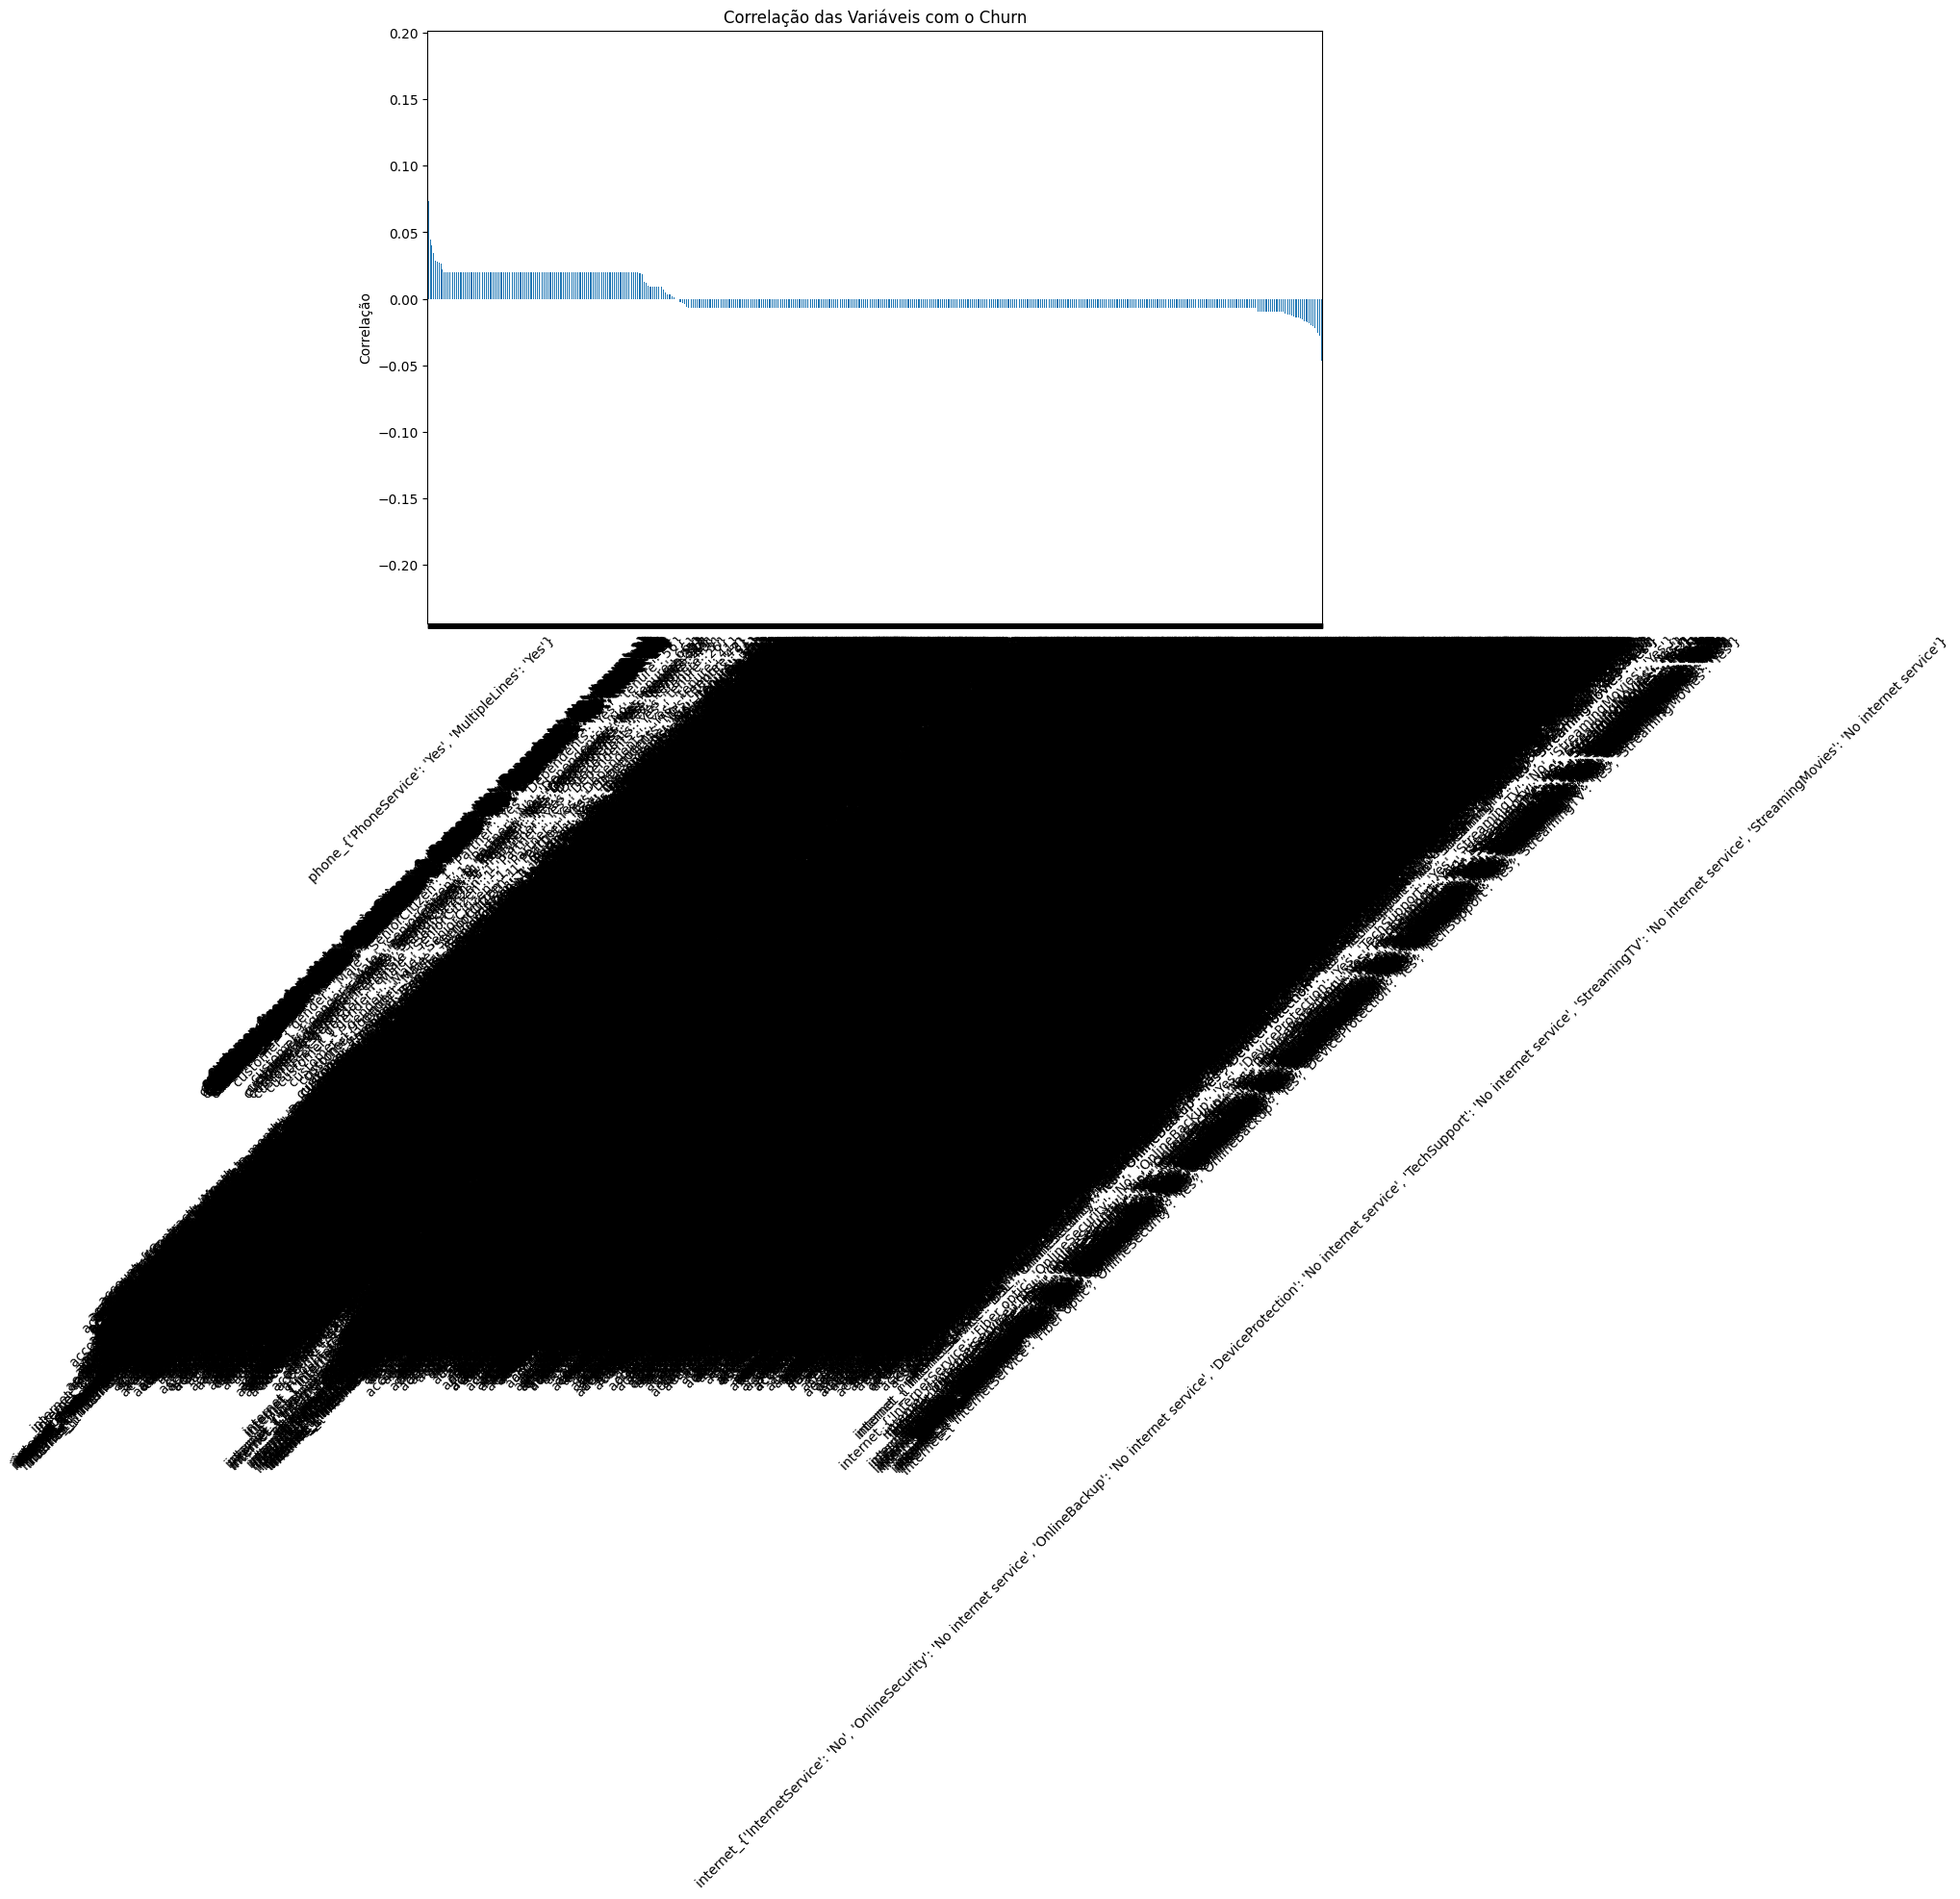

Características relevantes selecionadas: 27
["customer_{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 1}", "customer_{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 2}", "customer_{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 4}", "customer_{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 1}", "customer_{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes', 'tenure': 72}", "customer_{'gender': 'Female', 'SeniorCitizen': 1, 'Partner': 'No', 'Dependents': 'No', 'tenure': 1}", "customer_{'gender': 'Female', 'SeniorCitizen': 1, 'Partner': 'No', 'Dependents': 'No', 'tenure': 2}", "customer_{'gender': 'Female', 'SeniorCitizen': 1, 'Partner': 'Yes', 'Dependents': 'No', 'tenure': 1}", "customer_{'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 1}", "customer_{'gender': 'Ma

In [6]:
# 2. Análise de correlação
print("Analisando correlações...")
plt.figure(figsize=(12, 8))
correlacao = X.corrwith(y)
correlacao.sort_values(ascending=False).plot(kind='bar')
plt.title('Correlação das Variáveis com o Churn')
plt.ylabel('Correlação')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Selecionar as características mais relevantes (correlação absoluta > 0.05)
caracteristicas_relevantes = correlacao[abs(correlacao) > 0.05].index
print(f"Características relevantes selecionadas: {len(caracteristicas_relevantes)}")
print(list(caracteristicas_relevantes))

X_selected = X[caracteristicas_relevantes]

In [7]:
# 3. Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dados de treino: {X_train.shape}")
print(f"Dados de teste: {X_test.shape}")

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Dados de treino: (5813, 27)
Dados de teste: (1454, 27)


In [9]:
# 4. Treinamento dos modelos
print("\nTreinando modelos...")

# Modelo 1: Regressão Logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_prob_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# Modelo 2: Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_pred_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]


Treinando modelos...



Avaliando modelos...

--- Regressão Logística ---
Acurácia: 0.7785

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1080
           1       0.62      0.37      0.46       374

    accuracy                           0.78      1454
   macro avg       0.71      0.64      0.66      1454
weighted avg       0.76      0.78      0.76      1454



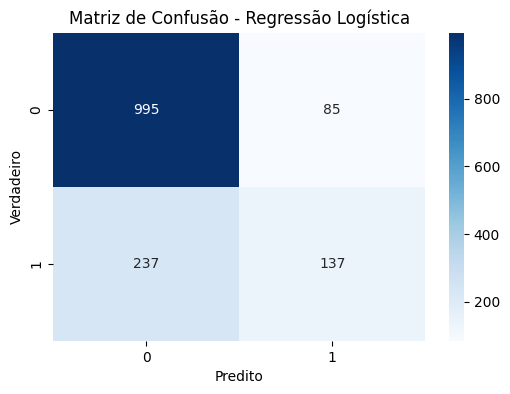

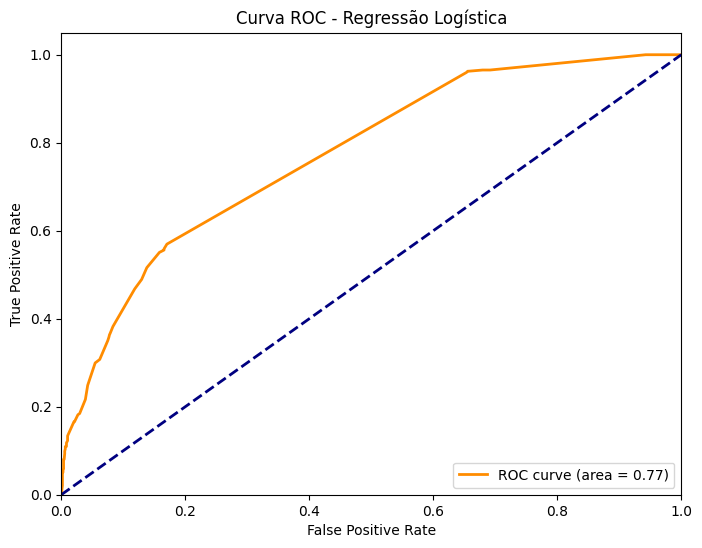


--- Random Forest ---
Acurácia: 0.7744

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1080
           1       0.61      0.34      0.43       374

    accuracy                           0.77      1454
   macro avg       0.71      0.63      0.65      1454
weighted avg       0.75      0.77      0.75      1454



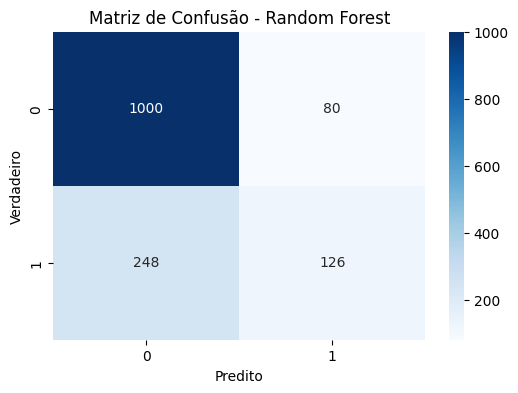

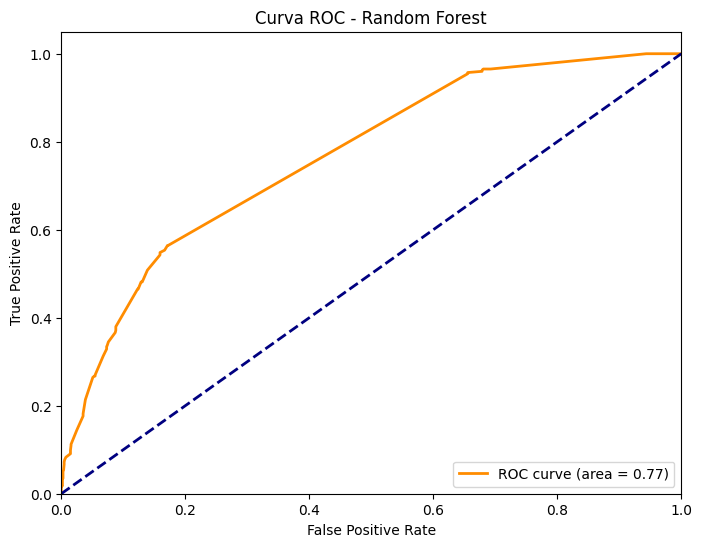

In [10]:
# 5. Avaliação dos modelos
print("\nAvaliando modelos...")

# Função para mostrar métricas
def avaliar_modelo(nome, y_real, y_pred, y_pred_prob=None):
    print(f"\n--- {nome} ---")
    print(f"Acurácia: {accuracy_score(y_real, y_pred):.4f}")
    print("\nRelatório de Classificação:")
    print(classification_report(y_real, y_pred))

    # Matriz de confusão
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_real, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome}')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    plt.show()

    # Curva ROC (se probabilidades forem fornecidas)
    if y_pred_prob is not None:
        fpr, tpr, _ = roc_curve(y_real, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Curva ROC - {nome}')
        plt.legend(loc="lower right")
        plt.show()

# Avaliar ambos os modelos
avaliar_modelo("Regressão Logística", y_test, y_pred_log, y_pred_prob_log)
avaliar_modelo("Random Forest", y_test, y_pred_rf, y_pred_prob_rf)

Analisando importância das variáveis...


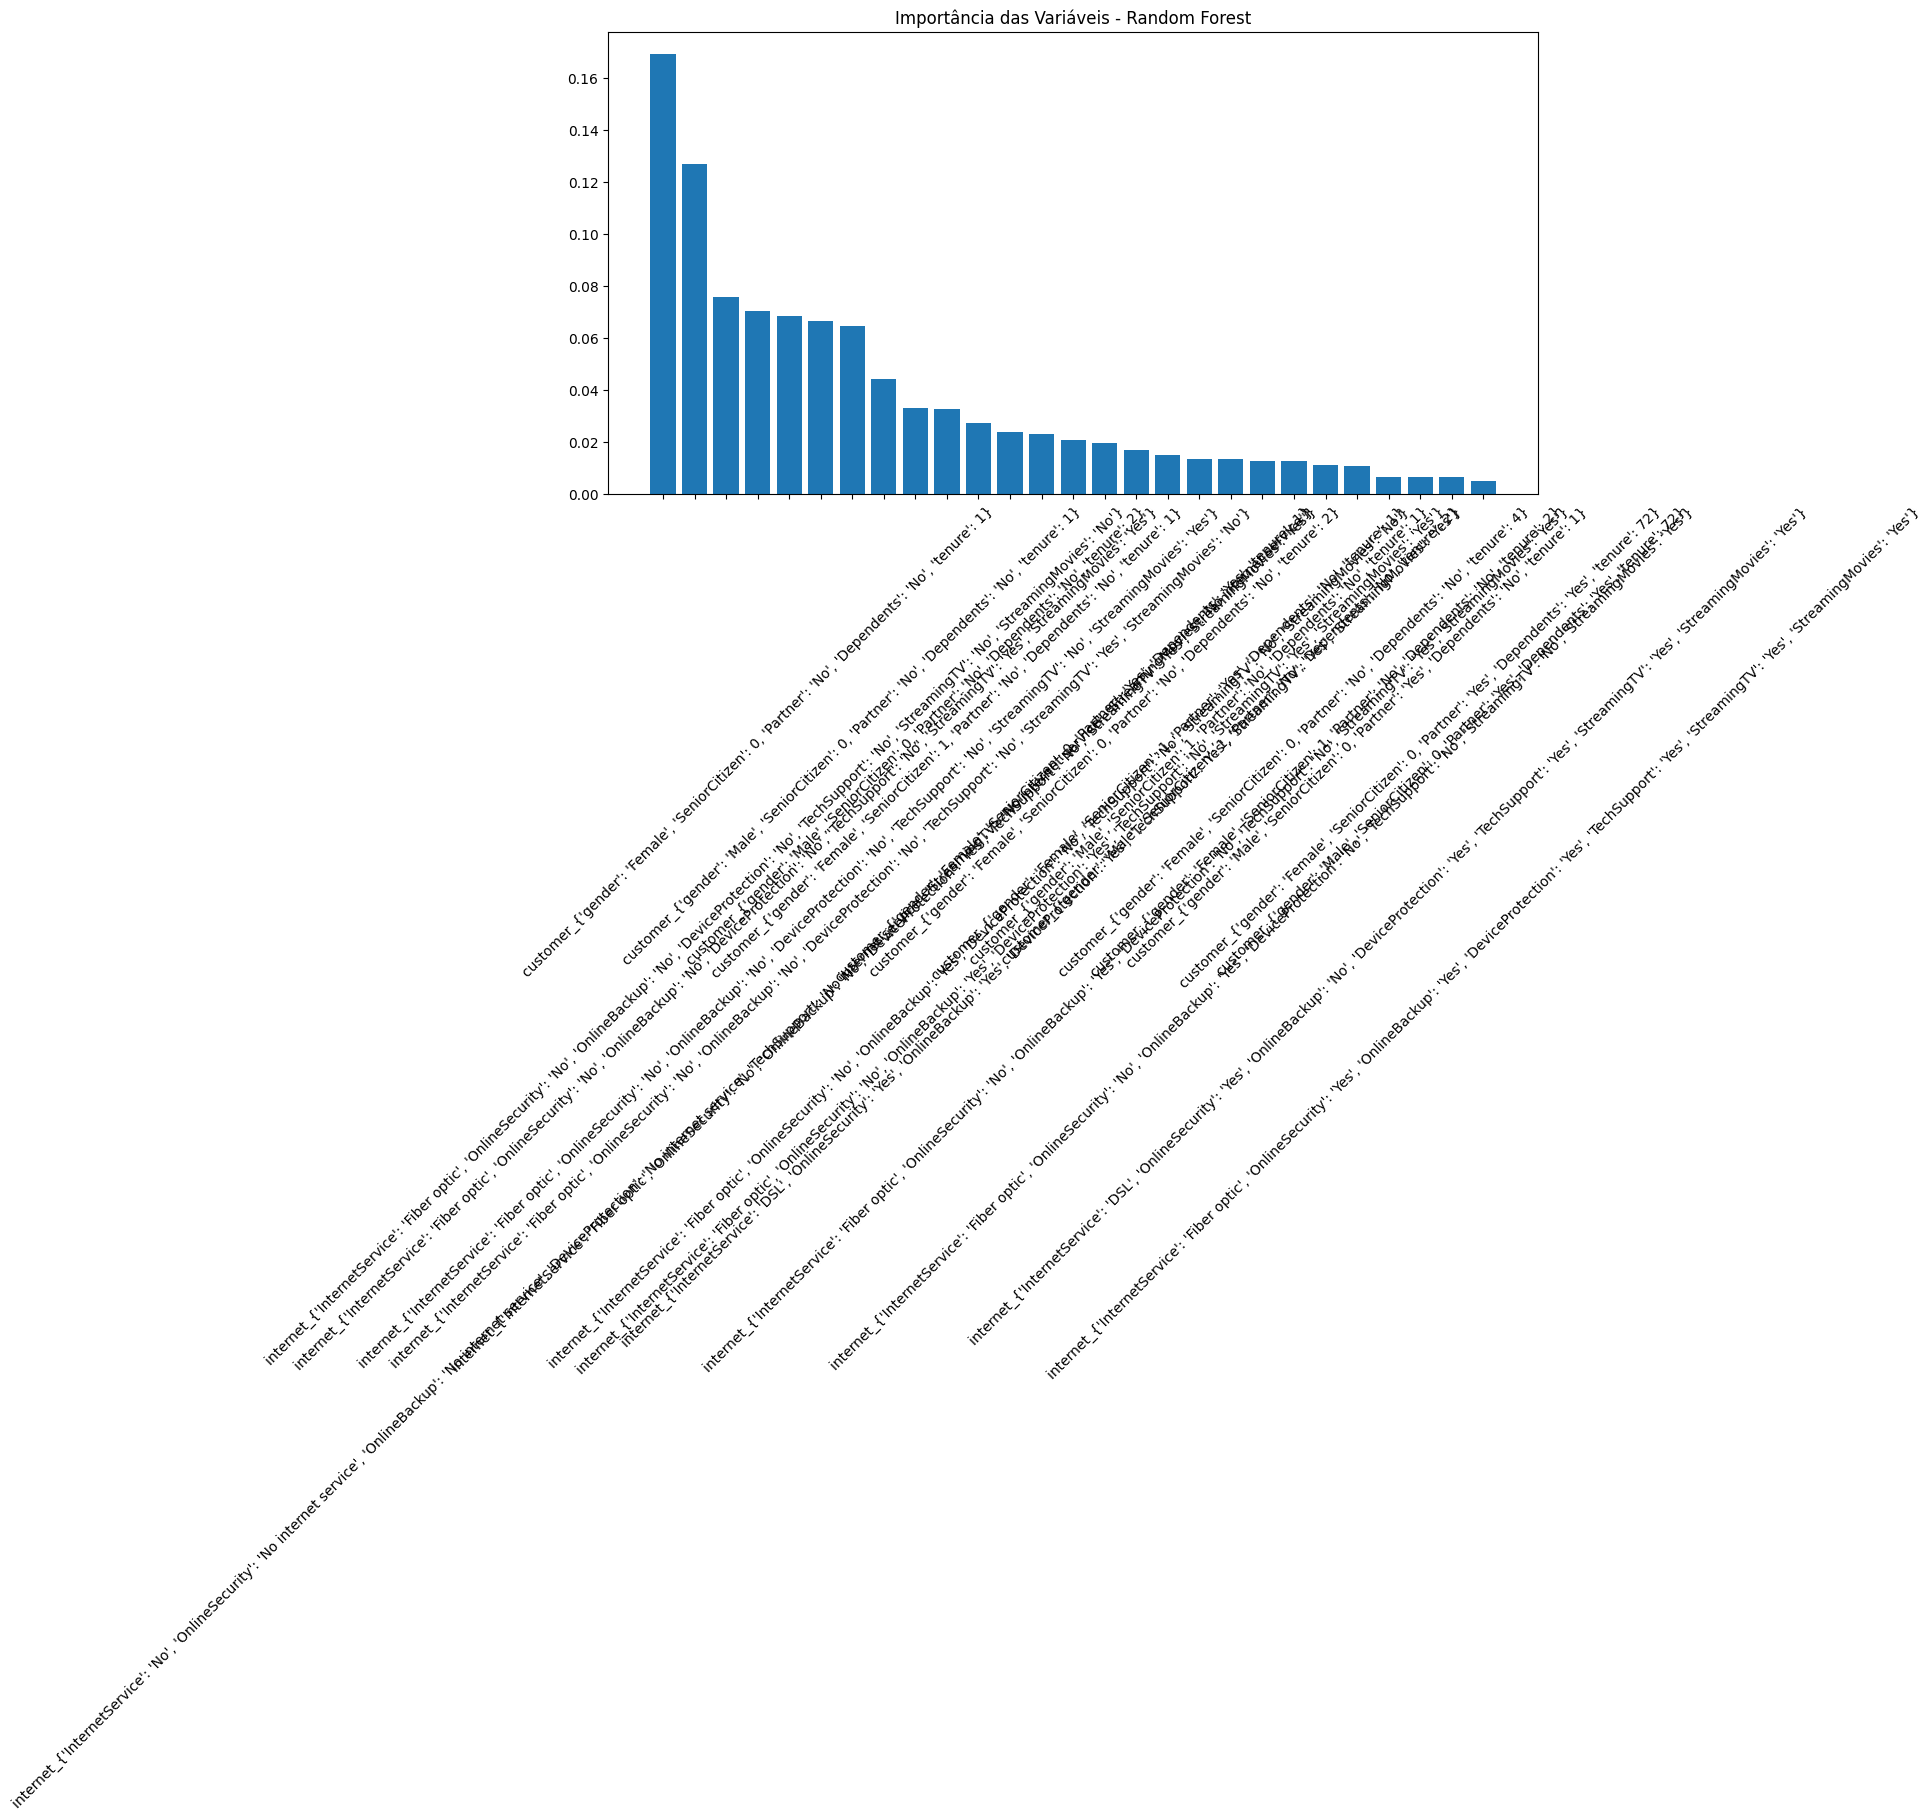


Top 10 variáveis mais importantes:
1. internet_{'InternetService': 'No', 'OnlineSecurity': 'No internet service', 'OnlineBackup': 'No internet service', 'DeviceProtection': 'No internet service', 'TechSupport': 'No internet service', 'StreamingTV': 'No internet service', 'StreamingMovies': 'No internet service'}: 0.1692
2. internet_{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'No'}: 0.1268
3. internet_{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'Yes', 'StreamingMovies': 'Yes'}: 0.0759
4. customer_{'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No', 'tenure': 1}: 0.0706
5. internet_{'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovie

In [11]:
# 6. Importância das variáveis
print("Analisando importância das variáveis...")

# Importância para Random Forest
importancia = rf.feature_importances_
indices = np.argsort(importancia)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importância das Variáveis - Random Forest")
plt.bar(range(X_selected.shape[1]), importancia[indices])
plt.xticks(range(X_selected.shape[1]), X_selected.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

# Mostrar as variáveis mais importantes
print("\nTop 10 variáveis mais importantes:")
for i, idx in enumerate(indices[:10]):
    print(f"{i+1}. {X_selected.columns[idx]}: {importancia[idx]:.4f}")

In [12]:
# 7. Conclusão estratégica
print("\n" + "="*60)
print("CONCLUSÃO ESTRATÉGICA")
print("="*60)

print("\n1. DESEMPENHO DOS MODELOS:")
print(f"   - Regressão Logística: {accuracy_score(y_test, y_pred_log):.2%} de acurácia")
print(f"   - Random Forest: {accuracy_score(y_test, y_pred_rf):.2%} de acurácia")

print("\n2. PRINCIPAIS FATORES QUE INFLUENCIAM O CHURN:")
for i, idx in enumerate(indices[:5]):
    nome_variavel = X_selected.columns[idx]
    importancia_valor = importancia[idx]

    # Traduzir nomes técnicos para insights de negócio
    if 'Contract' in nome_variavel:
        print(f"   {i+1}. Tipo de Contrato: Clientes com contratos mensais têm maior propensão a cancelar")
    elif 'InternetService' in nome_variavel:
        print(f"   {i+1}. Tipo de Internet: Clientes com fibra ótica apresentam maior taxa de evasão")
    elif 'SeniorCitizen' in nome_variavel:
        print(f"   {i+1}. Faixa Etária: Clientes idosos são mais propensos a cancelar")
    elif 'PaymentMethod' in nome_variavel:
        print(f"   {i+1}. Método de Pagamento: Pagamentos eletrônicos estão associados a menor churn")
    elif 'tenure' in nome_variavel:
        print(f"   {i+1}. Tempo como Cliente: Clientes recentes têm maior probabilidade de cancelar")
    else:
        print(f"   {i+1}. {nome_variavel}: {importancia_valor:.4f} de importância")

print("\n3. RECOMENDAÇÕES ESTRATÉGICAS:")
print("   - Focar esforços de retenção em clientes com contratos mensais")
print("   - Investigar problemas de qualidade no serviço de fibra ótica")
print("   - Desenvolver programas de fidelidade para clientes idosos")
print("   - Oferecer descontos para conversão de contratos mensais para anuais")
print("   - Criar campanhas direcionadas para clientes novos (menos de 12 meses)")

print("\n4. PRÓXIMOS PASSOS:")
print("   - Refinar o modelo com técnicas de balanceamento de classes")
print("   - Implementar sistema de alerta para clientes com alta probabilidade de churn")
print("   - Desenvolver dashboard de monitoramento contínuo")
print("   - Testar modelos mais complexos (XGBoost, Redes Neurais)")

# Salvar o modelo treinado para uso futuro
import joblib
joblib.dump(rf, 'modelo_churn_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nModelo e scaler salvos como 'modelo_churn_rf.pkl' e 'scaler.pkl'")


CONCLUSÃO ESTRATÉGICA

1. DESEMPENHO DOS MODELOS:
   - Regressão Logística: 77.85% de acurácia
   - Random Forest: 77.44% de acurácia

2. PRINCIPAIS FATORES QUE INFLUENCIAM O CHURN:
   1. Tipo de Internet: Clientes com fibra ótica apresentam maior taxa de evasão
   2. Tipo de Internet: Clientes com fibra ótica apresentam maior taxa de evasão
   3. Tipo de Internet: Clientes com fibra ótica apresentam maior taxa de evasão
   4. Faixa Etária: Clientes idosos são mais propensos a cancelar
   5. Tipo de Internet: Clientes com fibra ótica apresentam maior taxa de evasão

3. RECOMENDAÇÕES ESTRATÉGICAS:
   - Focar esforços de retenção em clientes com contratos mensais
   - Investigar problemas de qualidade no serviço de fibra ótica
   - Desenvolver programas de fidelidade para clientes idosos
   - Oferecer descontos para conversão de contratos mensais para anuais
   - Criar campanhas direcionadas para clientes novos (menos de 12 meses)

4. PRÓXIMOS PASSOS:
   - Refinar o modelo com técnicas 